# vprec

In [1]:
# Parameters
variable = "vprec"
stream = "native"
long_name = "Virtual liquid precip into ocean due to SSS restoring"


In [2]:
from IPython.display import display, Markdown

In [3]:
# Dynamically generate markdown content
markdown_text = f" This notebook compares area-weighted maps, in some cases, vertical profiles for {variable} in different basins."

# Display the updated markdown content
display(Markdown(markdown_text))

 This notebook compares area-weighted maps, in some cases, vertical profiles for vprec in different basins.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%%capture 
# comment above line to see details about the run(s) displayed
import sys, os
sys.path.append(os.path.abspath(".."))
from misc import *
import glob
print("Last update:", date.today())
%matplotlib inline

In [6]:
months = ['January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']

In [7]:
# load data
ds = []
for c, p in zip(casename, climo_path):
  file = glob.glob(p+'{}.{}.{}.??????-??????.nc'.format(c, stream, variable))[0]
  ds.append(xr.open_dataset(file))

In [8]:
def identify_xyz_dims(dims):
    dims = tuple(dims)

    z_options = ['zl', 'z_l', 'zi', 'z_i']
    y_options = ['yh', 'yq']
    x_options = ['xh', 'xq']

    z_dim = next((dim for dim in dims if dim in z_options), None)
    y_dim = next((dim for dim in dims if dim in y_options), None)
    x_dim = next((dim for dim in dims if dim in x_options), None)

    # Set default values for coordinates and area
    x_coord = y_coord = area_var = None

    if y_dim == 'yh' and x_dim == 'xh':
        x_coord = 'geolon'
        y_coord = 'geolat'
        area_var = 'areacello'
    elif y_dim == 'yq' and x_dim == 'xh':
        x_coord = 'geolon_v'
        y_coord = 'geolat_v'
        area_var = 'areacello_cv'
    elif y_dim == 'yh' and x_dim == 'xq':
        x_coord = 'geolon_u'
        y_coord = 'geolat_u'
        area_var = 'areacello_cu'

    return x_dim, y_dim, z_dim, x_coord, y_coord, area_var


In [9]:
dims = identify_xyz_dims(ds[0][variable+'_annual_mean'].dims)

In [10]:
def annual_plot(variable, dims, label):
    area = grd_xr[0][dims[5]].fillna(0)
    x = dims[0]; y = dims[1]; z = dims[2]
    lon = dims[3]; lat = dims[4] 
    model = []
    for i in range(len(label)):
        if z is None:
            model.append(np.ma.masked_invalid(ds[i][variable+'_annual_mean'].values))
        else:
            model.append(np.ma.masked_invalid(ds[i][variable+'_annual_mean'].isel({z: 0}).values))

        if i == 0:
            xyplot(model[i], 
                grd_xr[i].geolon.values, grd_xr[i].geolat.values, area.values,
                title = 'Annual mean '+str(variable)+ ' ('+str(ds[0].units)+')', 
                suptitle= label[i]+', '+ str(start_date) + ' to ' + str(end_date), 
                extend='max')
        else:
            xyplot((model[i]-model[0]), 
                grd_xr[i].geolon.values, grd_xr[i].geolat.values, area.values,
                title = 'Annual mean '+str(variable)+ ' ('+str(ds[0].units)+')', 
                suptitle= label[i]+' - '+label[0]+', '+ str(start_date) + ' to ' + str(end_date), 
                extend='max')
            
    fig, ax = plt.subplots(figsize=(8,4))
    for i in range(len(label)):
        if z is None:
            ds[i][variable+'_annual_mean'].weighted(area).mean(x).plot(y=y, 
                                            ax=ax, label=label[i])
        else:
            ds[i][variable+'_annual_mean'].isel({z: 0}).weighted(area).mean(x).plot(y=y, 
                                            ax=ax, label=label[i])
            
    ax.set_title('Zonally averaged '+str(variable)+' ('+str(ds[0].units)+'), annual mean')
    ax.grid()
    ax.legend();
    return

## Annual mean

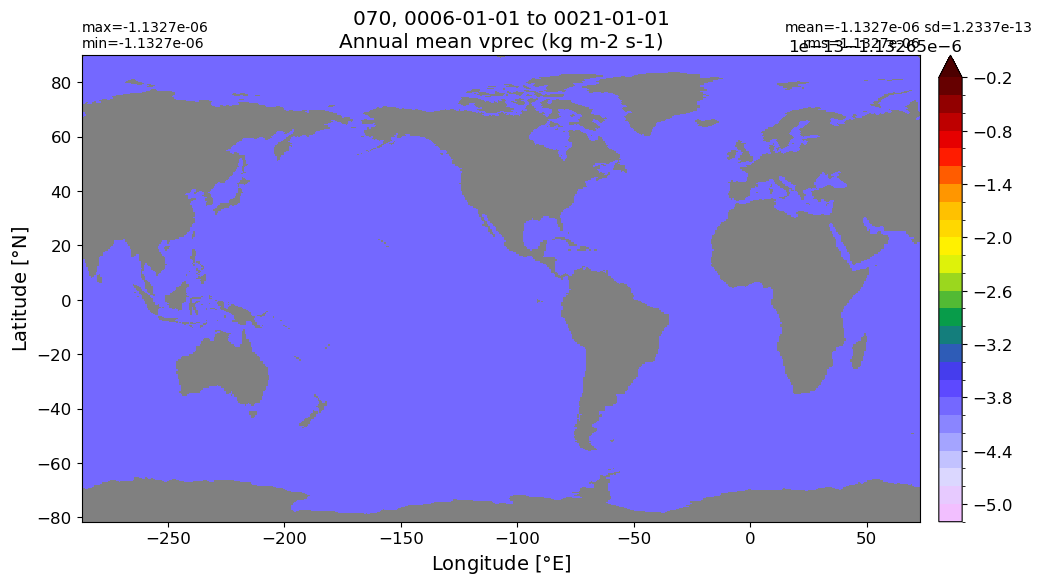

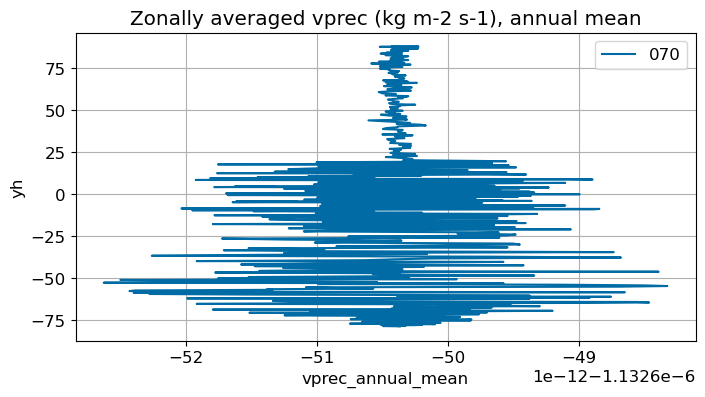

In [11]:
annual_plot(variable, dims, label)

## Monthly climatology

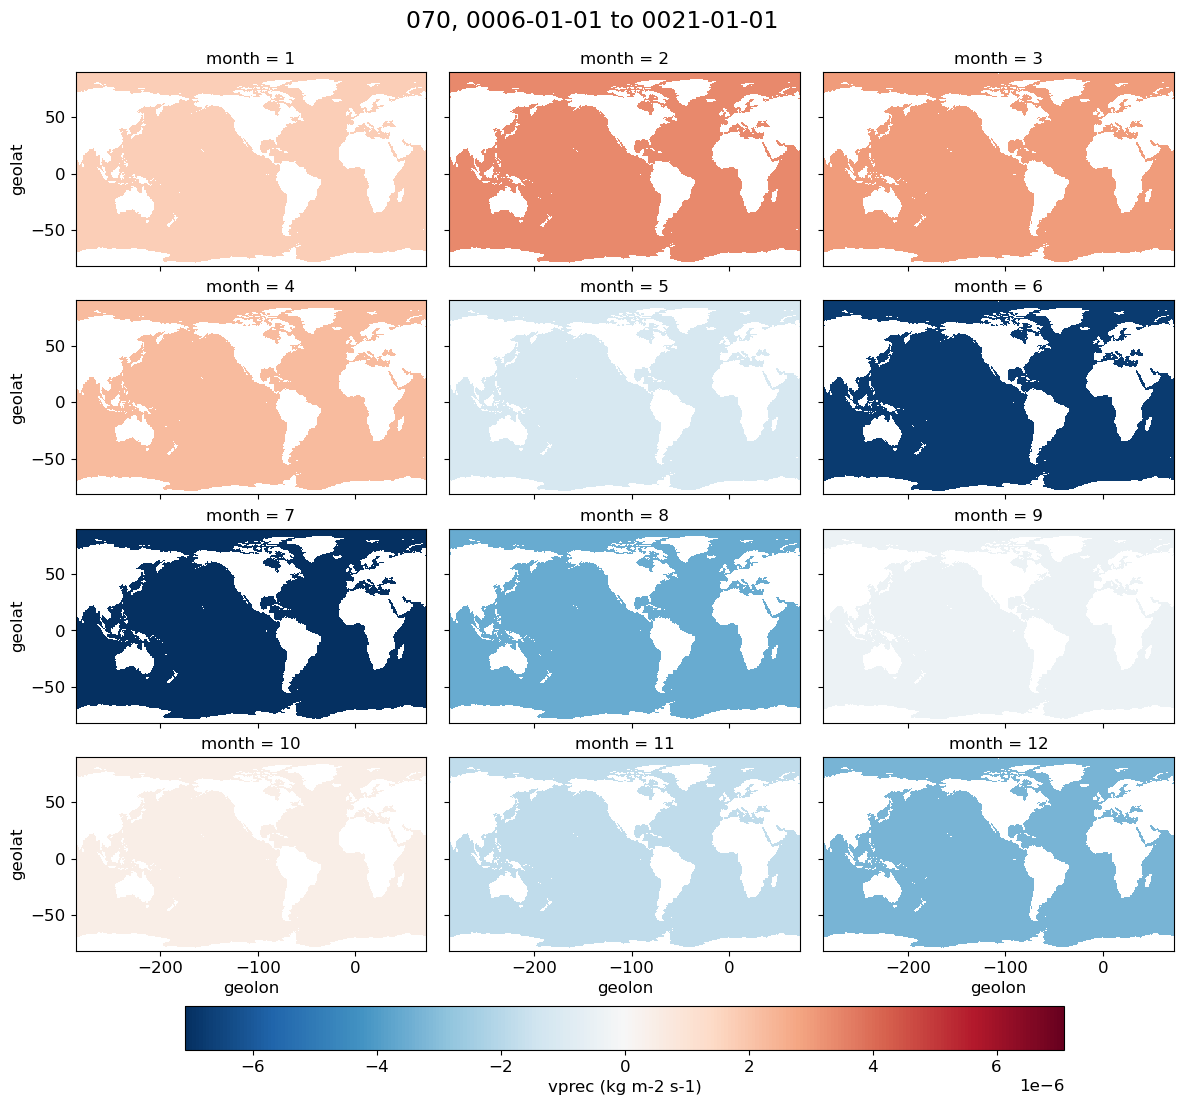

In [12]:
area = grd_xr[0][dims[5]].fillna(0)
x = dims[0]; y = dims[1]; z = dims[2]
lon = dims[3]; lat = dims[4]
model = []
for i in range(len(label)):
    if z is None:
        model.append(ds[i][variable+'_monthly_climatology'])
    else:
        model.append(ds[i][variable+'_monthly_climatology'].isel({z: 0}))
        
    if i == 0:
        g = model[i].plot(x='geolon', y='geolat', col='month', col_wrap=3,
            figsize=(12,12), robust=True,
            cbar_kwargs={"label": variable + ' ({})'.format(str(ds[0].units)),
                        "orientation": "horizontal", 'shrink': 0.8, 'pad': 0.05})
        
        plt.suptitle(label[i]+ ', ' +str(start_date) + ' to ' + str(end_date), y=1.02, fontsize=17)  

    else:
        g = (model[i]-model[0]).plot(x='geolon', y='geolat', col='month', col_wrap=3,
            figsize=(12,12), robust=True,
            cbar_kwargs={"label": variable + ' ({})'.format(str(ds[0].units)),
                        "orientation": "horizontal", 'shrink': 0.8, 'pad': 0.05})
        plt.suptitle(label[i] + ' - ' + label[0]+ ', ' +str(start_date) + ' to ' + str(end_date), 
                     y=1.02, fontsize=17)  

In [13]:
def monthly_plot(variable, dims, label, m):
    area = grd_xr[0][dims[5]].fillna(0)
    x = dims[0]; y = dims[1]; z = dims[2]
    lon = dims[3]; lat = dims[4]
          
    fig, ax = plt.subplots(figsize=(8,4))
    for i in range(len(label)):
        if z is None:
            ds[i][variable+'_monthly_climatology'].isel(month=m).weighted(area).mean(x).plot(y=y, 
                                               ax=ax, label=label[i])
        else:
            ds[i][variable+'_monthly_climatology'].isel({z: 0, 'month': m}).weighted(area).mean(x).plot(y=y, 
                                                ax=ax, label=label[i])
    ax.set_title(str(months[m])+', zonally averaged '+str(variable)+' ('+str(ds[0].units)+')')
    ax.grid()
    ax.legend();
    return

### January

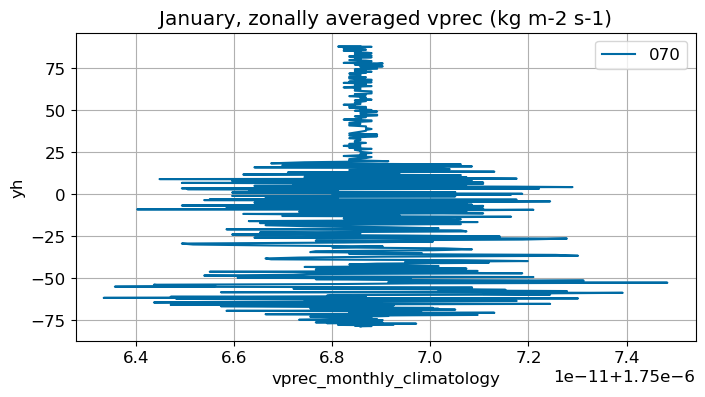

In [14]:
m=0
monthly_plot(variable, dims, label, m)

### February

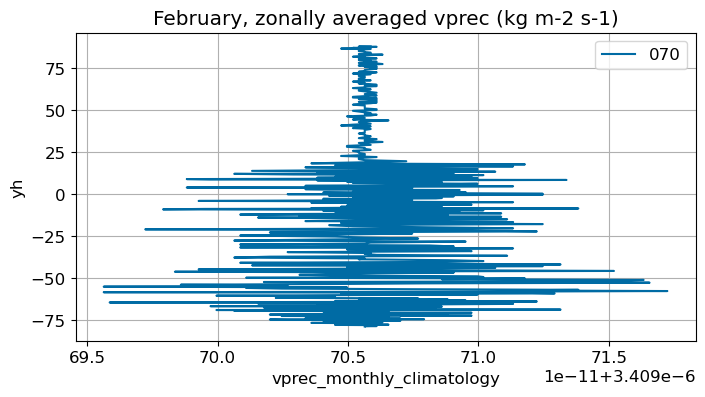

In [15]:
m=1
monthly_plot(variable, dims, label, m)

### March

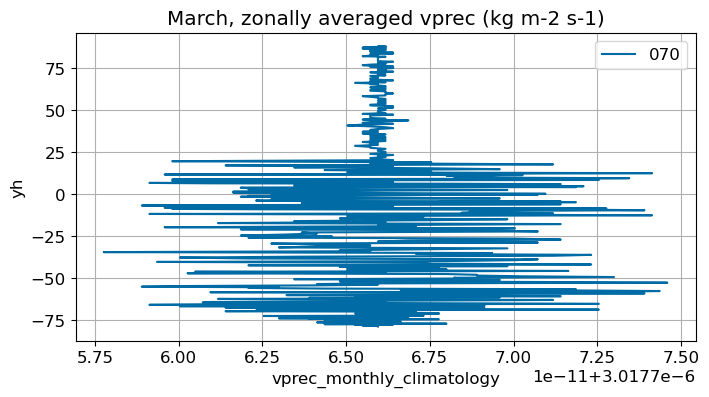

In [16]:
m=2
monthly_plot(variable, dims, label, m)

### April

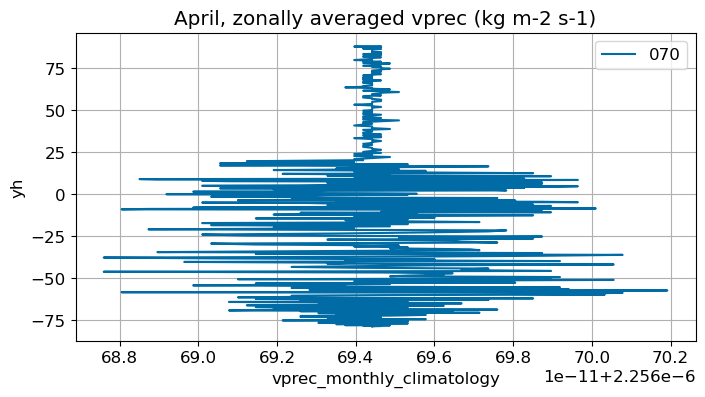

In [17]:
m=3
monthly_plot(variable, dims, label, m)

### May

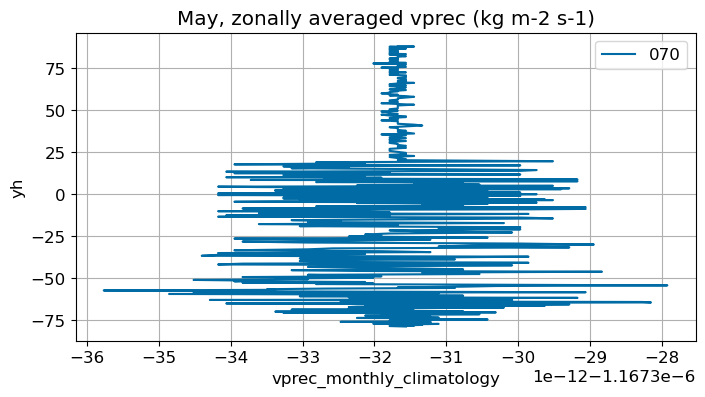

In [18]:
m=4
monthly_plot(variable, dims, label, m)

### June

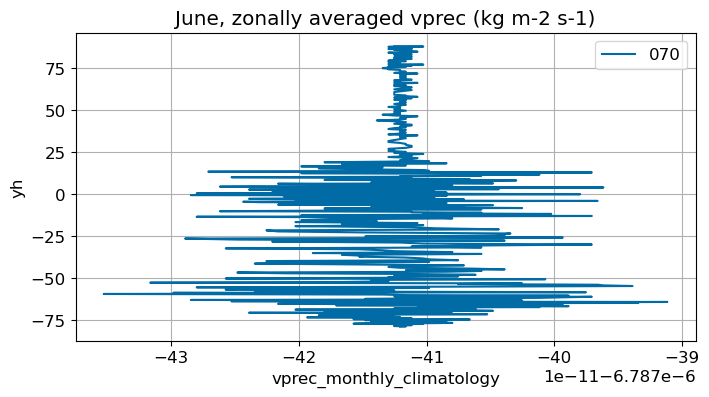

In [19]:
m=5
monthly_plot(variable, dims, label, m)

### July

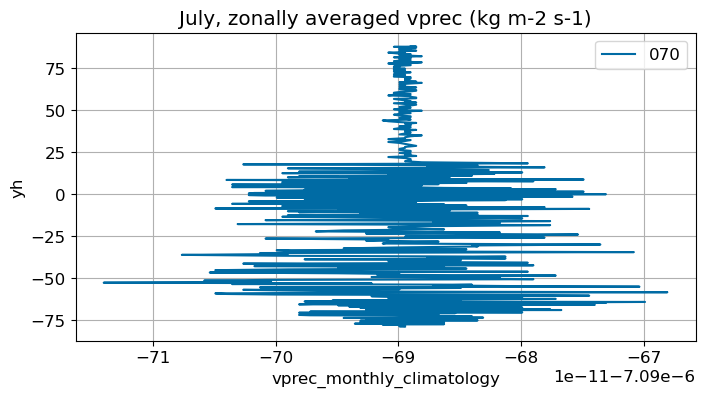

In [20]:
m=6
monthly_plot(variable, dims, label, m)

### August

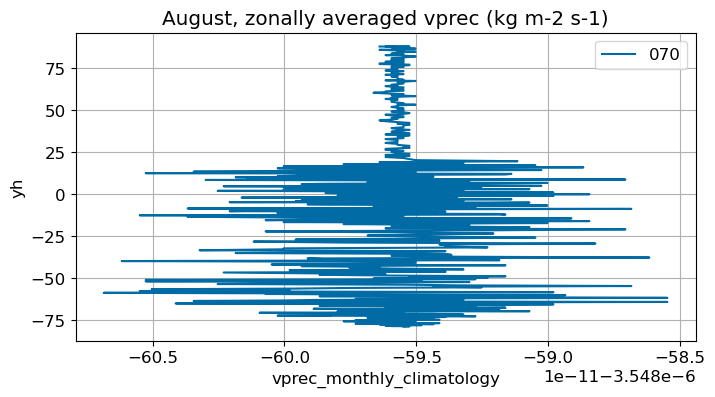

In [21]:
m=7
monthly_plot(variable, dims, label, m)

### September

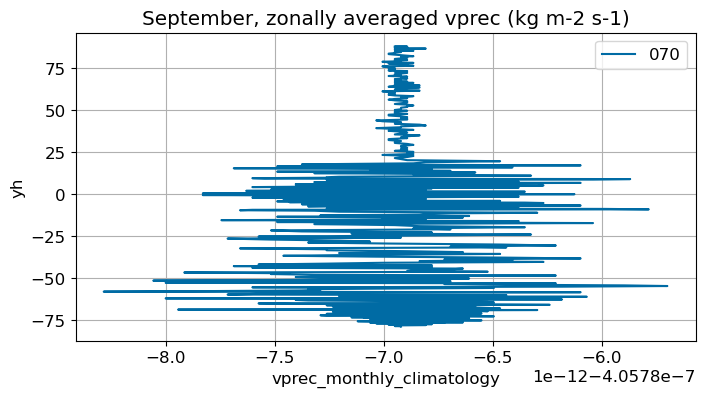

In [22]:
m=8
monthly_plot(variable, dims, label, m)

### October

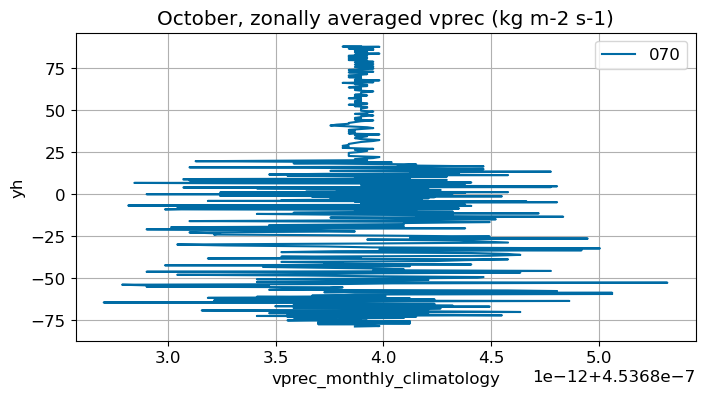

In [23]:
m=9
monthly_plot(variable, dims, label, m)

### November

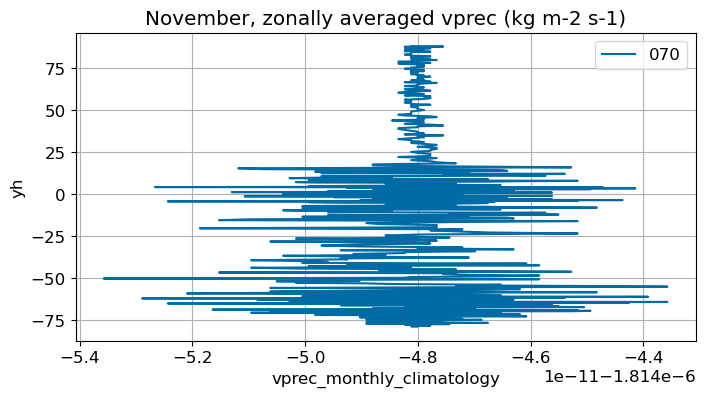

In [24]:
m=10
monthly_plot(variable, dims, label, m)

### December

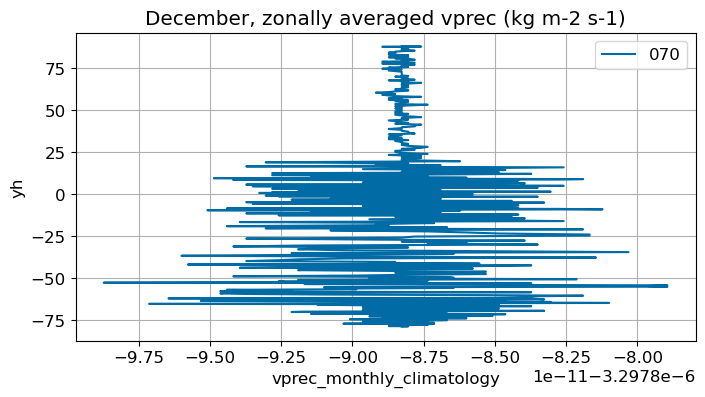

In [25]:
m=11
monthly_plot(variable, dims, label, m)

## By basins

### Monthly climo @ surface

In [26]:
# GMM, update this
basin_code = xr.open_dataset('/glade/work/gmarques/cesm/tx2_3/basin_masks/basin_masks_tx2_3v2_20250318.nc')['basin_masks']

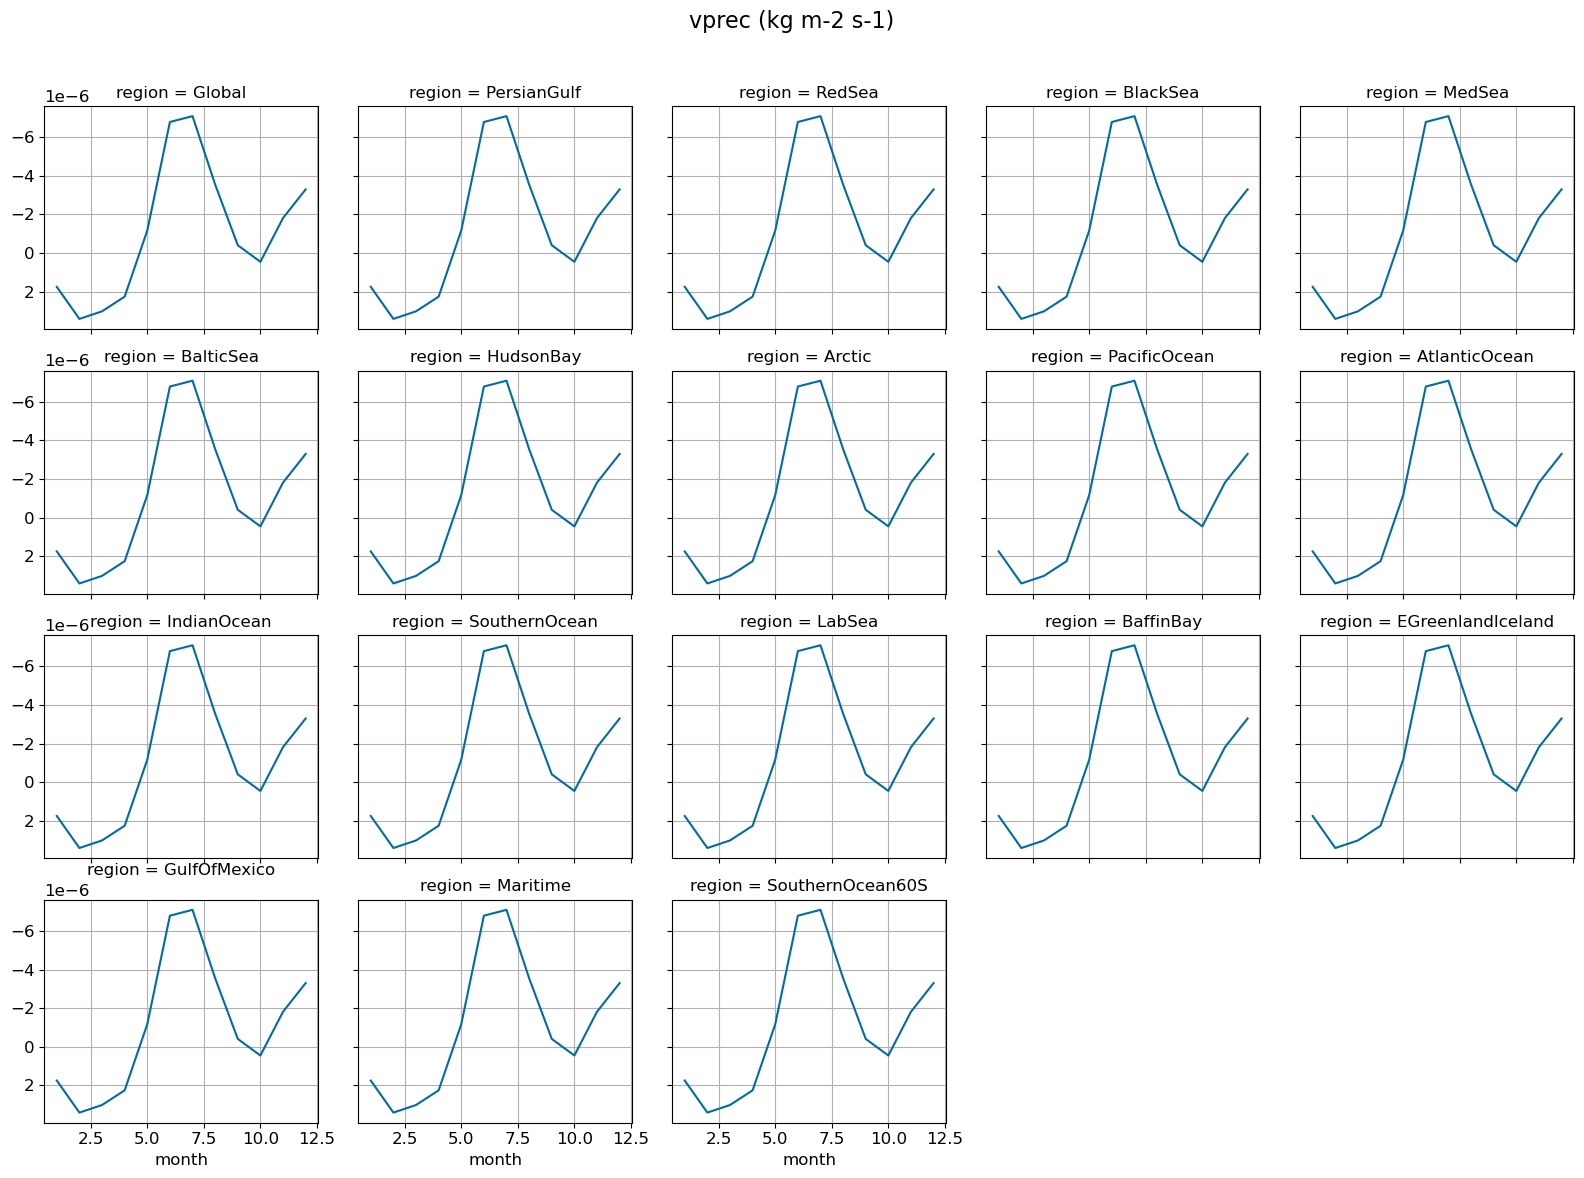

In [27]:
area = grd_xr[0][dims[5]].fillna(0)
x = dims[0]; y = dims[1]; z = dims[2]
model_mean_wgt = []
    
for i in range(len(label)):
    basin_code_dummy = basin_code.rename({'yh': y, 'xh': x})
    if z is None:
        model = ds[i][variable+'_monthly_climatology']
    else:
        model = ds[i][variable+'_monthly_climatology'].isel({z: 0})
    
    model_mean_wgt.append((model * basin_code_dummy).weighted(area*basin_code_dummy).mean(dim=[y, x]))
        
for i in range(len(label)):
    g = model_mean_wgt[i].plot(x="month", yincrease=False, col="region", col_wrap=5, label=label[i])
    
fig = g.fig  # not g.figure
fig.suptitle(str(variable)+' ('+str(ds[0].units)+')', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
for ax in g.axes.flat:
    ax.grid(True);
ax.legend()

### Vertical profiles
Averaged over annual means

In [28]:
z_max=1000 # change this to 6000 to see full profile

if stream == 'z' and (z == 'z_l' or z == 'z_i'):

    model_mean_wgt = []
    
    for i in range(len(label)):
        basin_code_dummy = basin_code.rename({'yh': y, 'xh': x})
        model = ds[i][variable+'_annual_mean']
        
        model_mean_wgt.append((model * basin_code_dummy).weighted(area*basin_code_dummy).mean(dim=[y, x]))
            
    for i in range(len(label)):
        g = model_mean_wgt[i].sel(**{z: slice(0., z_max)}).plot(y=z, yincrease=False, col="region", col_wrap=5, label=label[i])
    
    fig = g.fig  # not g.figure
    fig.suptitle(str(variable)+' ('+str(ds[0].units)+')', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    for ax in g.axes.flat:
        ax.grid(True);